In [3]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import weather_routing
import pandas
import math

In [5]:
year = 2024
##################
min_lat = 21.1
max_lat = 34.1
max_lng = -118
min_lng = -158
# Waypoints for the TransPac 
waypoints = pandas.DataFrame([
    (33.69853, -118.25085, 'Pt. Fermin Bouy'),
    (33.48177, -118.64101, 'Catalina West End'),
    #(21.24296, -157.81775, 'Diamond Head Bouy'),
            ], columns=['lat', 'lng', 'name'])
# July 1st, 12:00 PST
Start_Date = f"{year}0701"
Start_Time = 19 #19:00 UTC
##################
#grib_files_dir = "historical_gribs/2024"
wind_data_dir = f"historical_wind_data/{year}"

In [6]:
waypoints

,lat,lng,name
0,33.69853,-118.25085,Pt. Fermin Bouy
1,33.48177,-118.64101,Catalina West End


In [7]:
(FCdate, FCtime,_) = weather_routing.get_grib_time(Start_Date, Start_Time)

In [8]:
rhumb_route, rhumb_route_t = weather_routing.simulate_shortest_path(
        waypoints.iloc[0]['lat'], waypoints.iloc[0]['lng'],
        waypoints.iloc[1]['lat'], waypoints.iloc[1]['lng'],
        simulation_time=0,
        FCdate=FCdate,
        FCtime=FCtime,
        wind_data_dir=wind_data_dir
        )
print(f"Rhumb route takes {rhumb_route_t} steps")

starting time: 20240701 18 2024-07-01 11:00:00-07:00
0: twa=132.2 mag=202.2 dtg=19.8 sog=4.7
1: twa=132.2 mag=206.3 dtg=16.3 sog=4.7
2: twa=135 mag=217.5 dtg=13.0 sog=4.4
3: twa=150 mag=237.7 dtg=10.1 sog=3.5
4: twa=150 mag=299.6 dtg=7.1 sog=3.5
5: twa=165 mag=257.4 dtg=4.2 sog=2.9
6: twa=165 mag=277.5 dtg=1.5 sog=2.9
7: twa=180 mag=250.8 dtg=1.1 sog=2.6
Rhumb route takes 8 steps


In [31]:
def plot_isochrons_routes(isochrons, rhumb_route=None, min_route=None, saved_isochrons=None):
    import plotly.graph_objects as go
    import plotly.express as px
    # Create the figure
    fig = go.Figure()
    
    for t,isochron in enumerate(isochrons):
        isochron_lats = []
        isochron_lngs = []
        for route in isochron:
            isochron_lats.append(route[-1]['lat'])
            isochron_lngs.append(route[-1]['lng'])
            if t>0:
                # # Add the first route (red line)
                fig.add_trace(go.Scattermapbox(
                    lat=[route[-2]['lat'], route[-1]['lat']],
                    lon=[route[-2]['lng'], route[-1]['lng']],
                    mode='lines',
                    line=dict(color='rgba(255, 0, 0, 0.25)', width=2),
                    hovertext=f"{route[-1]['date']}"
                ))
        fig.add_trace(go.Scattermapbox(
            lat=isochron_lats,
            lon=isochron_lngs,
            mode='lines',
            line=dict(color='rgba(255, 165, 0, 0.75)', width=2),
            hovertext=f"isochron={t+1}"
        ))

    if saved_isochrons is not None:
        for t,isochron in enumerate(saved_isochrons):
            isochron_lats = []
            isochron_lngs = []
            for route in isochron:
                isochron_lats.append(route[-1]['lat'])
                isochron_lngs.append(route[-1]['lng'])
                if t>0:
                    # # Add the first route (red line)
                    fig.add_trace(go.Scattermapbox(
                        lat=[route[-2]['lat'], route[-1]['lat']],
                        lon=[route[-2]['lng'], route[-1]['lng']],
                        mode='lines',
                        line=dict(color='rgba(0, 0, 0, 0.25)', width=2),
                        hovertext=f"{route[-1]['date']}"
                    ))
            fig.add_trace(go.Scattermapbox(
                lat=isochron_lats,
                lon=isochron_lngs,
                mode='lines',
                line=dict(color='rgba(0, 0, 0, 0.75)', width=2),
                hovertext=f"isochron={t+1}"
            ))
    
    if rhumb_route is not None:
        fig.add_trace(go.Scattermapbox(
            lat=rhumb_route['lat'],
            lon=rhumb_route['lng'],
            mode='lines',
            line=dict(color='blue', width=2),
            hovertext=rhumb_route['date']
        ))
    
    if min_route is not None:
        min_route_dt = pandas.DataFrame(min_route)
        fig.add_trace(go.Scattermapbox(
            lat=min_route_dt['lat'],
            lon=min_route_dt['lng'],
            mode='lines',
            line=dict(color='black', width=2),
            hovertext=min_route_dt['date']
        ))
    
    
    # Add scatter points for waypoints
    scatter_points = px.scatter_mapbox(waypoints, 
                                       lat="lat", 
                                       lon="lng", 
                                       hover_name="name")
    fig.add_traces(scatter_points.data)
    # Add the shore boundary line to the figure
    for shore_boundary in weather_routing.shore_boundaries:
        boundary_lat, boundary_lon = zip(*shore_boundary)
        fig.add_trace(go.Scattermapbox(
            lat=boundary_lat,
            lon=boundary_lon,
            mode='lines',
            line=dict(color='green', width=2),
            #name='Boundary'  # Legend label
        ))
    # Update layout for the map
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=9,
        mapbox_center={"lat": 33.7, "lon": -118.5},
        margin={"r":0, "t":0, "l":0, "b":0},
       # width=800,
        height=600,
        showlegend=False
    )
    # Show the plot
    fig.show()

In [53]:

lat_start = waypoints.iloc[0]['lat']
lng_start = waypoints.iloc[0]['lng']
lat_end = waypoints.iloc[1]['lat']
lng_end = waypoints.iloc[1]['lng']
time_step_size = 1 #hour
isochrons=[[
    [{  #start
        'lat':lat_start,
        'lng':lng_start,
        'date': weather_routing.FCdatetime_to_localtime(FCdate, FCtime,0),
        'dtw' : weather_routing.haversine_distance(lat_start,lng_start,lat_end,lng_end), #Distance to Waypoint
        'tdt' : 0, #total distance travled
    }]
]]
saved_nc_isochrons = isochrons.copy()

end_simulation_time = 1
###
for simulation_time in range(1,end_simulation_time+1):
    print(f"Calculating simulation_time={simulation_time}")
    (convex_hull, saved_isochron) = weather_routing.take_isochron_step(
            isochrons[simulation_time-1], simulation_time-1, FCdate, FCtime, 
            wind_data_dir,lat_start,lng_start,lat_end, lng_end, time_step_size) 
    isochrons.append(convex_hull)
    saved_nc_isochrons.append(saved_isochron)


Calculating simulation_time=1
   mag 118.1732808818415 deviation=118.23409440720371 too big
   mag 21.7732808818415 deviation=145.36590559279625 too big
   mag 121.9732808818415 deviation=114.4340944072037 too big
   mag 17.973280881841504 deviation=141.5659055927963 too big
   mag 129.9732808818415 deviation=106.4340944072037 too big
   mag 9.973280881841504 deviation=133.5659055927963 too big
   mag 144.9732808818415 deviation=91.4340944072037 too big
   mag 354.9732808818415 deviation=118.5659055927963 too big
mag 159.9732808818415 (33.69853,-118.25085) (33.60400718499465,-118.20948655499828)
   mag 339.9732808818415 deviation=103.5659055927963 too big
mag 179.9732808818415 (33.69853,-118.25085) (33.599430171631425,-118.25079451630212)
    mag 319.9732808818415 crosses land
mag 189.9732808818415 (33.69853,-118.25085) (33.60633940627002,-118.2703143622098)
    mag 309.9732808818415 crosses land
mag 204.9732808818415 (33.69853,-118.25085) (33.6314881873833,-118.28834792801968)
    mag

In [54]:
for route in isochrons[-1]:
    print(route[-1]['mag'])

159.9732808818415
179.9732808818415
189.9732808818415
202.1732808818415
204.9732808818415
219.9732808818415
264.9732808818415


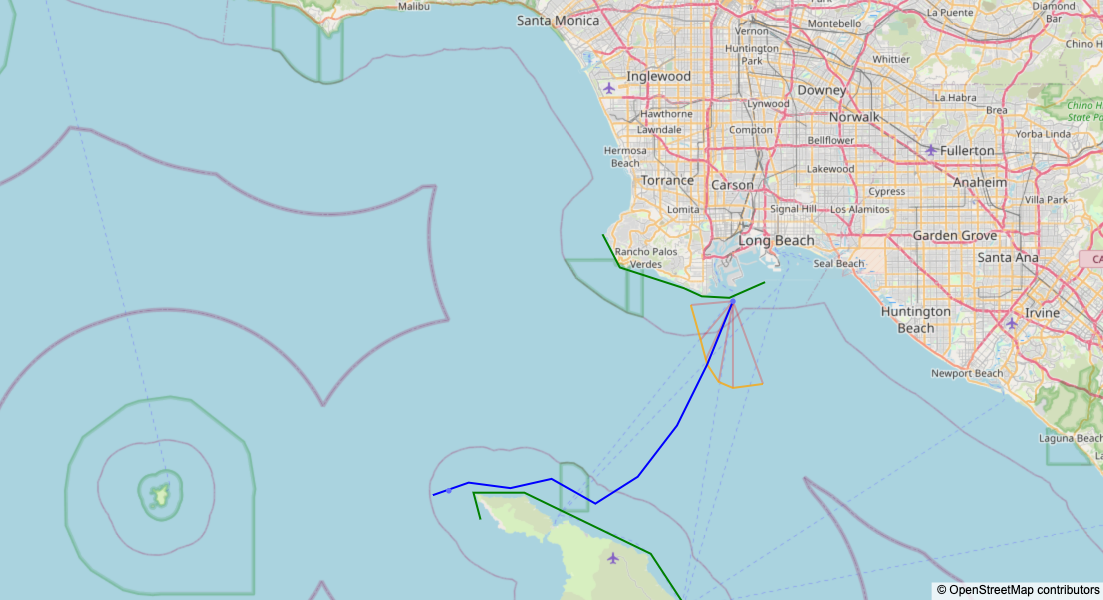

In [55]:
plot_isochrons_routes(isochrons, rhumb_route=rhumb_route)
#plot_isochrons_routes(isochrons, rhumb_route=rhumb_route, saved_isochrons=saved_nc_isochrons)
#plot_isochrons_routes(isochrons)


In [ ]:
#isochrons

In [ ]:
# min_dtg = 30
# min_route = None
# for route in isochrons[5]:
#     #print(route[-1]['dtw'])
#     if route[-1]['dtw'] < min_dtg:
#         min_dtg = route[-1]['dtw']
#         min_route = route
    

In [ ]:
#len(min_route)

In [ ]:
#len(rhumb_route)

In [ ]:
#min_route